In [246]:
import pandas as pd
import matplotlib as plt
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

# 11_2_LEARN-DataAnalysisML

<a target="_blank" href="https://colab.research.google.com/github/hiyama341/ConStrain/blob/main/colab_notebooks/11_2_LEARN_DataAnalysisML.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

We can import the data repository like this: 

In [247]:
# cloning the data repo
!git clone https://github.com/hiyama341/ConStrain_on_google_colab.git

fatal: destination path 'ConStrain_on_google_colab' already exists and is not an empty directory.


## 0. Intro

This is the second notebook showcasing how we can use machine learning techniques to predict the best promoter-gene combinations. We will use various machine learning algorithms through the package H2O. We continue the workflow by using Machine Learning to predict the best promoter:gene combinations of the remaining library that was generated in [09_2_BUILD_CombinatorialLibrary](../colab_notebooks/09_2_BUILD_CombinatorialLibrary.ipynb) and analyzed in [10_2_TEST_Library_Characterization](../colab_notebooks/07_1_LEARN_DataAnalysis.ipynb). 

What is different in this notebook is that we investigate how the ML faired in predicting strictosidine values and we compare how a ML model trained on two rounds of data differ from the one we used in notebook [07_1_LEARN_DataAnalysis](../colab_notebooks/07_1_LEARN_DataAnalysis.ipynb)


## Project overview - Use ML to predicte best promoter:gene combinations 

**Hypothesis**
1. Specific combinations of CPR / G8H homologs and corresponding expression levels can remove the G8H bottleneck in the Strictosidine pathway

Aim: To test the hypothesis

**2nd library**

Tasks
1. dgRNA
2. Base strain
3. Library
4. Phenotyping
**5. Machine Learning**
   - Predict the best promoter:gene combinations


## 1. Setup H2O AutoML

In [248]:
%%capture 
!pip install h2o

In [249]:
import h2o
from h2o.automl import H2OAutoML

In [250]:
# If this doesnt work - install java. 
# Start the H2O cluster (locally)
h2o.init(ip="localhost", min_mem_size_GB=8)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_361"; Java(TM) SE Runtime Environment (build 1.8.0_361-b09); Java HotSpot(TM) 64-Bit Server VM (build 25.361-b09, mixed mode)
  Starting server from /Users/lucaslevassor/opt/anaconda3/lib/python3.9/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/tmpp995dy3a
  JVM stdout: /var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/tmpp995dy3a/h2o_lucaslevassor_started_from_python.out
  JVM stderr: /var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/tmpp995dy3a/h2o_lucaslevassor_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,20 secs
H2O_cluster_timezone:,Europe/Copenhagen
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.38.0.4
H2O_cluster_version_age:,26 days
H2O_cluster_name:,H2O_from_python_lucaslevassor_l835h5
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.576 Gb
H2O_cluster_total_cores:,0
H2O_cluster_allowed_cores:,0
H2O_cluster_status:,"locked, healthy"


### 1.1 Import our dataframe as h20 object

Train a model based on the target and the df

In [251]:
first_input_for_ml = pd.read_csv('ConStrain_on_google_colab/data/09-AutoML/input_to_ml/first_round/input_for_ml_1st_iteration_all_analytics.csv')
first_input_for_ml 

,Line_name,0,1,2,3,Amt_uM_Strictosidine,Amt_norm
0,yp49_A01,1,2,5,1,0.271199,0
1,yp49_C01,1,2,5,9,0.149626,0
2,yp49_D01,2,4,7,3,0.049042,0
3,yp49_E01,2,1,5,7,0.096246,0
4,yp49_F01,3,3,6,1,7.365141,25
...,...,...,...,...,...,...,...
162,yp51_C12,8,3,7,2,0.000000,0
163,yp51_D12,8,2,7,6,0.202343,0
164,yp51_E12,8,1,6,10,0.153556,0
165,yp50_F05,6,1,8,2,4.656777,13


### 1.2 Investigate how the predictions from the previous ML cycle matched the sampled strains 

In [254]:
# Run ML with new input 
second_input_for_ml = pd.read_csv('ConStrain_on_google_colab/data/09-AutoML/input_to_ml/second_round/input_for_ml_2nd_iteration_all_analytics.csv')
second_input_for_ml

,Line_name,0,1,2,3,Amt_uM_Strictosidine,Amt_norm
0,yp53_A01,4,1,5,2,2.546823,9
1,yp53_A02,4,1,5,2,7.921696,28
2,yp53_A04,4,2,5,2,22.597750,80
3,yp53_A06,5,1,5,2,34.235068,121
4,yp53_A07,5,2,6,2,44.719792,159
...,...,...,...,...,...,...,...
124,yp54_A04,4,1,6,1,4.326963,15
125,yp54_C04,5,2,6,3,26.634041,94
126,yp54_C09,3,1,6,3,13.122270,46
127,yp54_D12,5,1,6,6,1.049920,3


In [255]:
list_of_promoters = ["CYC1", "ENO2","PCK1","RPL15B", "CCW12", "TPI1","MLS1","URE2"]

promoter_dict = {i+1:list_of_promoters[i]for i in range(len(list_of_promoters))}


g8h_list_of_index = ["Cacu", "Opum","Cro","Vmin","Smus","Rsep","Oeu","Ccal"]
cpr_list_of_index = ["Cro", "Aan","Ara","Clo","Rse","Ahu","Ani","Cac","Oeu","Cpo"]

pg8h_list_of_index = ['CYC1', 'ENO2']
pcpr_list_of_index = ['CCW12', 'TPI1'] 


g8h_genotype = []
cpr_genotype = []
pg8h_genotype = []
pcpr_genotype = []

# adding index of genotypes to individual rows 
for index, row in second_input_for_ml.iterrows():
    # homologs
    g8h_name = g8h_list_of_index[int(row['0']-1)]
    cpr_name = cpr_list_of_index[int(row['3']-1)]
    
    # promoters
    pg8h_name =promoter_dict[row['1']]
    pcpr_name = promoter_dict[row['2']]
    
    
    # save the genotypes
    g8h_genotype.append(g8h_name)
    cpr_genotype.append(cpr_name)
    pg8h_genotype.append(pg8h_name)
    pcpr_genotype.append(pcpr_name)

second_input_for_ml['G8H'] = g8h_genotype
second_input_for_ml['pG8H'] = pg8h_genotype
second_input_for_ml['pCPR'] = pcpr_genotype
second_input_for_ml['CPR'] = cpr_genotype
second_input_for_ml

,Line_name,0,1,2,3,Amt_uM_Strictosidine,Amt_norm,G8H,pG8H,pCPR,CPR
0,yp53_A01,4,1,5,2,2.546823,9,Vmin,CYC1,CCW12,Aan
1,yp53_A02,4,1,5,2,7.921696,28,Vmin,CYC1,CCW12,Aan
2,yp53_A04,4,2,5,2,22.597750,80,Vmin,ENO2,CCW12,Aan
3,yp53_A06,5,1,5,2,34.235068,121,Smus,CYC1,CCW12,Aan
4,yp53_A07,5,2,6,2,44.719792,159,Smus,ENO2,TPI1,Aan
...,...,...,...,...,...,...,...,...,...,...,...
124,yp54_A04,4,1,6,1,4.326963,15,Vmin,CYC1,TPI1,Cro
125,yp54_C04,5,2,6,3,26.634041,94,Smus,ENO2,TPI1,Ara
126,yp54_C09,3,1,6,3,13.122270,46,Cro,CYC1,TPI1,Ara
127,yp54_D12,5,1,6,6,1.049920,3,Smus,CYC1,TPI1,Ahu


In [256]:
second_input_for_ml["Names"] = second_input_for_ml[['G8H', 'pG8H','pCPR', 'CPR']].agg('-'.join, axis=1)
second_input_for_ml =second_input_for_ml[['Names', 'Amt_norm', 'Line_name']]
second_input_for_ml

,Names,Amt_norm,Line_name
0,Vmin-CYC1-CCW12-Aan,9,yp53_A01
1,Vmin-CYC1-CCW12-Aan,28,yp53_A02
2,Vmin-ENO2-CCW12-Aan,80,yp53_A04
3,Smus-CYC1-CCW12-Aan,121,yp53_A06
4,Smus-ENO2-TPI1-Aan,159,yp53_A07
...,...,...,...
124,Vmin-CYC1-TPI1-Cro,15,yp54_A04
125,Smus-ENO2-TPI1-Ara,94,yp54_C04
126,Cro-CYC1-TPI1-Ara,46,yp54_C09
127,Smus-CYC1-TPI1-Ahu,3,yp54_D12


In [258]:
first_round_top_producers = pd.read_csv('ConStrain_on_google_colab/data/09-AutoML/Top20_predictions/first_round/top20_ML_predicted_after_first_DBTL_1st_analytics.csv')
first_round_top_producers = first_round_top_producers.sort_values(by='Predicted_strict_production', ascending=False)

# add names columns
first_round_top_producers["Names"] = first_round_top_producers[['G8H', 'pG8H','pCPR', 'CPR']].agg('-'.join, axis=1)
first_round_top_producers  = first_round_top_producers[['Names', 'Predicted_strict_production']]
first_round_top_producers['Predicted_strict_production_rank_pct']= first_round_top_producers['Predicted_strict_production'].rank(pct=True)
first_round_top_producers

,Names,Predicted_strict_production,Predicted_strict_production_rank_pct
0,Smus-ENO2-TPI1-Rse,169.288180,1.000000
1,Rsep-ENO2-TPI1-Ara,162.151856,0.999106
2,Smus-ENO2-CCW12-Ara,161.904255,0.998213
3,Smus-CYC1-TPI1-Ara,157.638727,0.997319
4,Smus-ENO2-TPI1-Aan,156.976470,0.996425
...,...,...,...
1114,Rsep-CYC1-TPI1-Ani,-9.125477,0.004468
1115,Ccal-ENO2-TPI1-Cac,-12.768510,0.003575
1116,Rsep-PCK1-CCW12-Ara,-12.901417,0.002681
1117,Ccal-ENO2-CCW12-Cac,-16.241411,0.001787


In [259]:
second_input_for_ml

,Names,Amt_norm,Line_name
0,Vmin-CYC1-CCW12-Aan,9,yp53_A01
1,Vmin-CYC1-CCW12-Aan,28,yp53_A02
2,Vmin-ENO2-CCW12-Aan,80,yp53_A04
3,Smus-CYC1-CCW12-Aan,121,yp53_A06
4,Smus-ENO2-TPI1-Aan,159,yp53_A07
...,...,...,...
124,Vmin-CYC1-TPI1-Cro,15,yp54_A04
125,Smus-ENO2-TPI1-Ara,94,yp54_C04
126,Cro-CYC1-TPI1-Ara,46,yp54_C09
127,Smus-CYC1-TPI1-Ahu,3,yp54_D12


In [260]:
## merging the unsampled library with the second sampling
predicted_vs_sampled = pd.merge(first_round_top_producers, second_input_for_ml, on=['Names'])
predicted_vs_sampled['norm_strict_measured_rank'] = predicted_vs_sampled['Amt_norm'].rank(pct=True)
predicted_vs_sampled['Predicted_strict_production_rank_pct'] = predicted_vs_sampled['Predicted_strict_production'].rank(pct=True)

predicted_vs_sampled = predicted_vs_sampled.sort_values(by= 'Amt_norm', ascending = False)

In [261]:
predicted_vs_sampled

,Names,Predicted_strict_production,Predicted_strict_production_rank_pct,Amt_norm,Line_name,norm_strict_measured_rank
0,Smus-ENO2-TPI1-Rse,169.288180,0.995575,169,yp53_D09,1.000000
4,Smus-ENO2-TPI1-Aan,156.976470,0.964602,159,yp53_A07,0.986726
10,Rsep-ENO2-TPI1-Clo,103.496648,0.907080,159,yp53_C06,0.986726
31,Smus-CYC1-CCW12-Clo,57.162466,0.725664,143,yp53_C01,0.973451
32,Cro-ENO2-TPI1-Cro,56.438602,0.712389,138,yp54_B01,0.964602
...,...,...,...,...,...,...
84,Vmin-ENO2-CCW12-Ani,4.137479,0.261062,0,yp53_F02,0.092920
1,Smus-ENO2-TPI1-Rse,169.288180,0.995575,0,yp53_D12,0.092920
33,Cro-ENO2-TPI1-Cro,56.438602,0.712389,0,yp54_B02,0.092920
77,Smus-ENO2-CCW12-Ani,11.204736,0.314159,0,yp53_F05,0.092920


In [263]:
from constrain.plotting.plotting import correlation_plot

In [264]:
#correlation_plot(predicted_vs_sampled,"Amt_norm","Predicted_strict_production", size_height= 5, size_length = 5)

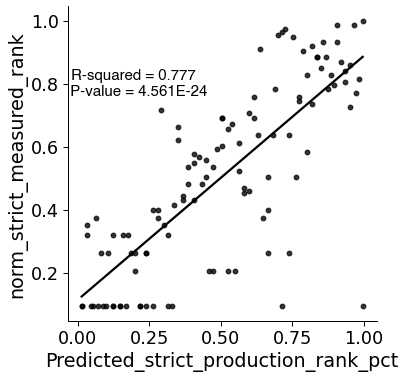

In [265]:
correlation_plot(predicted_vs_sampled,"Predicted_strict_production_rank_pct","norm_strict_measured_rank",size_height= 5, size_length = 5)

### 1.3 Concatting the dataframes for updating the model 

In [266]:
first_input_for_ml = pd.read_csv('ConStrain_on_google_colab/data/09-AutoML/input_to_ml/first_round/input_for_ml_1st_iteration_all_analytics.csv')
second_input_for_ml = pd.read_csv('ConStrain_on_google_colab/data/09-AutoML/input_to_ml/second_round/input_for_ml_2nd_iteration_all_analytics.csv')

We can add the first dataframe to the second. See below: 

In [267]:
new_input_for_ml = pd.concat([first_input_for_ml, second_input_for_ml])
new_input_for_ml

,Line_name,0,1,2,3,Amt_uM_Strictosidine,Amt_norm
0,yp49_A01,1,2,5,1,0.271199,0
1,yp49_C01,1,2,5,9,0.149626,0
2,yp49_D01,2,4,7,3,0.049042,0
3,yp49_E01,2,1,5,7,0.096246,0
4,yp49_F01,3,3,6,1,7.365141,25
...,...,...,...,...,...,...,...
124,yp54_A04,4,1,6,1,4.326963,15
125,yp54_C04,5,2,6,3,26.634041,94
126,yp54_C09,3,1,6,3,13.122270,46
127,yp54_D12,5,1,6,6,1.049920,3


### 1.4 Update dataframe Change 

In [268]:
df_test = h2o.H2OFrame(pd.concat([new_input_for_ml], axis='columns'))
df_test.describe()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


Rows:296
Cols:7

,Line_name,0,1,2,3,Amt_uM_Strictosidine,Amt_norm
type,string,int,int,int,int,real,int
mins,NaN,1.0,1.0,5.0,1.0,0.0,0.0
mean,NaN,4.773648648648647,2.1452702702702697,6.135135135135138,4.750000000000003,8.425198588094599,27.7972972972973
maxs,NaN,8.0,4.0,8.0,10.0,85.21014946,245.0
sigma,NaN,1.946604570553522,1.115003045338059,1.0554051268004114,2.5930153901508803,13.47666920488858,44.38536320958643
zeros,0,0,0,0,0,72,115
missing,0,0,0,0,0,0,0
0,yp49_A01,1.0,2.0,5.0,1.0,0.271198899,0.0
1,yp49_C01,1.0,2.0,5.0,9.0,0.149625874,0.0
2,yp49_D01,2.0,4.0,7.0,3.0,0.049041597,0.0


In [269]:
# Since the data is categorical we need to make it from numerical to categorical 
df_test['0']= df_test['0'].asfactor()
df_test['1']= df_test['1'].asfactor()
df_test['2'] = df_test['2'].asfactor()
df_test['3'] = df_test['3'].asfactor()

In [270]:
df_test.describe()

Rows:296
Cols:7

,Line_name,0,1,2,3,Amt_uM_Strictosidine,Amt_norm
type,string,enum,enum,enum,enum,real,int
mins,NaN,,,,,0.0,0.0
mean,NaN,,,,,8.425198588094599,27.7972972972973
maxs,NaN,,,,,85.21014946,245.0
sigma,NaN,,,,,13.47666920488858,44.38536320958643
zeros,0,,,,,72,115
missing,0,0,0,0,0,0,0
0,yp49_A01,1,2,5,1,0.271198899,0.0
1,yp49_C01,1,2,5,9,0.149625874,0.0
2,yp49_D01,2,4,7,3,0.049041597,0.0


### 1.5 If you dont want to run the AutoML skip the following paragraphs and go to paragraph 4.

## 2. RUN automl

Set some arguments for the autoML. 


Important here is that we dont split the dataset but rather keep the cross-validation validate a model internally, i.e., estimate the model performance without having to sacrifice a validation split. See: https://docs.h2o.ai/h2o/latest-stable/h2o-docs/cross-validation.html


Here we are defining the autoML object and after we can train it

In [66]:
# Select the columns we want to train on
feature_cols = ['0', '1', '2', '3']

# Initialize H2O autoML class
AutoML = H2OAutoML(
    max_runtime_secs=0,  # 1 hour =int(3600 * 1) , if unlimited time is wanted then set this to zero = 0
    max_models=None,  # None =  no limit
    nfolds=10,         # number of folds for k-fold cross-validation (nfolds=0 disables cross-validation)
    seed=1,            # Reproducibility
    sort_metric = "MAE",
    #exclude_algos = ["StackedEnsemble"], # Stacked ensemble cannot perform CV-holdout_predictions
    keep_cross_validation_predictions=True,
    #keep_cross_validation_models = True,
    #keep_cross_validation_fold_assignment = True, 
)

Train a model based on the target and the df. 

In [67]:
%%time

AutoML.train(
     x=feature_cols,
     y='Amt_norm',
     training_frame=df_test,
 )

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
CPU times: user 37.2 s, sys: 6.69 s, total: 43.9 s
Wall time: 59min 42s


Model Details
=============
H2OXGBoostEstimator : XGBoost
Model Key: XGBoost_lr_search_selection_AutoML_2_20230201_153113_select_grid_model_3


Model Summary: 
    number_of_trees
--  -----------------
    160

ModelMetricsRegression: xgboost
** Reported on train data. **

MSE: 362.72693937301756
RMSE: 19.04539155210566
MAE: 8.669277115850836
RMSLE: NaN
Mean Residual Deviance: 362.72693937301756

ModelMetricsRegression: xgboost
** Reported on cross-validation data. **

MSE: 544.7599421212705
RMSE: 23.340093018693615
MAE: 11.928834673923415
RMSLE: NaN
Mean Residual Deviance: 544.7599421212705

Cross-Validation Metrics Summary: 
                        mean      sd        cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
----------------------  --------  --------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
mae                     11.917    2.39606   14.5257       11.5357       12.51         14.8639       7.40361       14.1791       12.7468       9.01759       11.3582       11.029
mean_residual_deviance  544.723   234.855   622.094       397.664       487.356       1086.95       169.938       515.316       644.754       475.67        608.954       438.538
mse                     544.723   234.855   622.094       397.664       487.356       1086.95       169.938       515.316       644.754       475.67        608.954       438.538
r2                      0.682581  0.173342  0.554383      0.831341      0.721576      0.65435       0.906327      0.754315      0.742156      0.562592      0.303511      0.795258
residual_deviance       544.723   234.855   622.094       397.664       487.356       1086.95       169.938       515.316       644.754       475.67        608.954       438.538
rmse                    22.8485   5.0187    24.9418       19.9415       22.0761       32.9689       13.036        22.7006       25.392        21.8099       24.677        20.9413
rmsle                   0.967296  0.198859  1.32025       0.861789      nan           0.848778      nan           0.895199      nan           nan           nan           0.91047

Scoring History: 
    timestamp            duration    number_of_trees    training_rmse    training_mae    training_deviance
--  -------------------  ----------  -----------------  ---------------  --------------  -------------------
    2023-02-01 16:29:37  14.644 sec  0                  52.0437          27.6858         2708.55
    2023-02-01 16:29:37  14.653 sec  15                 37.0421          18.8615         1372.12
    2023-02-01 16:29:37  14.663 sec  30                 29.6927          15.1028         881.654
    2023-02-01 16:29:37  14.673 sec  45                 25.9249          13.0454         672.103
    2023-02-01 16:29:37  14.689 sec  60                 23.6073          11.635          557.306
    2023-02-01 16:29:37  14.700 sec  75                 22.0821          10.6045         487.621
    2023-02-01 16:29:37  14.713 sec  90                 21.0996          9.94098         445.194
    2023-02-01 16:29:37  14.731 sec  105                20.4077          9.44351         416.475
    2023-02-01 16:29:37  14.746 sec  120                19.9237          9.19005         396.955
    2023-02-01 16:29:37  14.788 sec  135                19.5522          8.97266         382.287
    2023-02-01 16:29:37  14.813 sec  150                19.2376          8.78334         370.084
    2023-02-01 16:29:37  14.840 sec  160                19.0454          8.66928         362.727

Variable Importances: 
variable    relative_importance    scaled_importance     percentage
----------  ---------------------  --------------------  ---------------------
1.2         197885.375             1.0                   0.17133735989982224
3.7         136921.40625           0.6919228176918077    0.11855222883776034
3.6         130585.2421875   

In [68]:
print('DOOOOOOONE')

DOOOOOOONE


## 3. Processing model . i.e. saving the best model and the leaderboard. 


In [69]:
## Saving the leaderboard ids
leaderboard = AutoML.leaderboard
model_ids = list(leaderboard['model_id'].as_data_frame().iloc[:,0])


In [70]:
# how to save any model
out_path = 'ConStrain_on_google_colab/data/09-AutoML/best_models/second_round/'
mdl = h2o.get_model(model_ids[1])
h2o.save_model(model=mdl, path=out_path, force=True)


'/Users/lucaslevassor/projects/ConStrain/colab_notebooks/ConStrain_on_google_colab/data/09-AutoML/best_models/second_round/StackedEnsemble_BestOfFamily_7_AutoML_2_20230201_153113'

In [71]:
len(model_ids)

774

Now we want to extract the best models

In [72]:
df_from_h2o_object = leaderboard.as_data_frame(use_pandas=True, header=True)
df_from_h2o_object

,model_id,mae,rmse,mse,rmsle,mean_residual_deviance
0,XGBoost_lr_search_selection_AutoML_2_20230201_...,11.928835,23.340093,544.759942,NaN,544.759942
1,StackedEnsemble_BestOfFamily_7_AutoML_2_202302...,12.004139,23.207078,538.568467,NaN,538.568467
2,StackedEnsemble_BestOfFamily_5_AutoML_2_202302...,12.068177,23.103751,533.783314,NaN,533.783314
3,XGBoost_grid_1_AutoML_2_20230201_153113_model_165,12.202119,23.809118,566.874091,NaN,566.874091
4,StackedEnsemble_BestOfFamily_4_AutoML_2_202302...,12.310970,24.014083,576.676198,NaN,576.676198
...,...,...,...,...,...,...
769,GBM_grid_1_AutoML_2_20230201_153113_model_6,28.109438,38.445424,1478.050651,NaN,1478.050651
770,GBM_grid_1_AutoML_2_20230201_153113_model_14,28.377779,39.226350,1538.706506,NaN,1538.706506
771,GBM_grid_1_AutoML_2_20230201_153113_model_27,28.483100,38.907762,1513.813944,NaN,1513.813944
772,GBM_grid_1_AutoML_2_20230201_153113_model_19,28.810229,39.500864,1560.318259,NaN,1560.318259


### 3.1 Saving the best model

In [73]:
best_model = AutoML.get_best_model()
best_model

Model Details
=============
H2OXGBoostEstimator : XGBoost
Model Key: XGBoost_lr_search_selection_AutoML_2_20230201_153113_select_grid_model_3


Model Summary: 
    number_of_trees
--  -----------------
    160

ModelMetricsRegression: xgboost
** Reported on train data. **

MSE: 362.72693937301756
RMSE: 19.04539155210566
MAE: 8.669277115850836
RMSLE: NaN
Mean Residual Deviance: 362.72693937301756

ModelMetricsRegression: xgboost
** Reported on cross-validation data. **

MSE: 544.7599421212705
RMSE: 23.340093018693615
MAE: 11.928834673923415
RMSLE: NaN
Mean Residual Deviance: 544.7599421212705

Cross-Validation Metrics Summary: 
                        mean      sd        cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
----------------------  --------  --------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
mae                     11.917    2.39606   14.5257       11.5357       12.51         14.8639       7.40361       14.1791       12.7468       9.01759       11.3582       11.029
mean_residual_deviance  544.723   234.855   622.094       397.664       487.356       1086.95       169.938       515.316       644.754       475.67        608.954       438.538
mse                     544.723   234.855   622.094       397.664       487.356       1086.95       169.938       515.316       644.754       475.67        608.954       438.538
r2                      0.682581  0.173342  0.554383      0.831341      0.721576      0.65435       0.906327      0.754315      0.742156      0.562592      0.303511      0.795258
residual_deviance       544.723   234.855   622.094       397.664       487.356       1086.95       169.938       515.316       644.754       475.67        608.954       438.538
rmse                    22.8485   5.0187    24.9418       19.9415       22.0761       32.9689       13.036        22.7006       25.392        21.8099       24.677        20.9413
rmsle                   0.967296  0.198859  1.32025       0.861789      nan           0.848778      nan           0.895199      nan           nan           nan           0.91047

Scoring History: 
    timestamp            duration    number_of_trees    training_rmse    training_mae    training_deviance
--  -------------------  ----------  -----------------  ---------------  --------------  -------------------
    2023-02-01 16:29:37  14.644 sec  0                  52.0437          27.6858         2708.55
    2023-02-01 16:29:37  14.653 sec  15                 37.0421          18.8615         1372.12
    2023-02-01 16:29:37  14.663 sec  30                 29.6927          15.1028         881.654
    2023-02-01 16:29:37  14.673 sec  45                 25.9249          13.0454         672.103
    2023-02-01 16:29:37  14.689 sec  60                 23.6073          11.635          557.306
    2023-02-01 16:29:37  14.700 sec  75                 22.0821          10.6045         487.621
    2023-02-01 16:29:37  14.713 sec  90                 21.0996          9.94098         445.194
    2023-02-01 16:29:37  14.731 sec  105                20.4077          9.44351         416.475
    2023-02-01 16:29:37  14.746 sec  120                19.9237          9.19005         396.955
    2023-02-01 16:29:37  14.788 sec  135                19.5522          8.97266         382.287
    2023-02-01 16:29:37  14.813 sec  150                19.2376          8.78334         370.084
    2023-02-01 16:29:37  14.840 sec  160                19.0454          8.66928         362.727

Variable Importances: 
variable    relative_importance    scaled_importance     percentage
----------  ---------------------  --------------------  ---------------------
1.2         197885.375             1.0                   0.17133735989982224
3.7         136921.40625           0.6919228176918077    0.11855222883776034
3.6         130585.2421875   

In [74]:
model_path = h2o.save_model(model=best_model, path="ConStrain_on_google_colab/data/09-AutoML/best_models/second_round/", force=True)

### 3.2 Exporting the leaderboard

In [75]:
# saving the leaderboard
out_path = 'ConStrain_on_google_colab/data/09-AutoML/leaderboards/second_round/'
h2o.export_file(leaderboard, os.path.join(out_path, 'aml_leaderboard.h2o'), force=True)

Export File progress: |██████████████████████████████████████████████████████████| (done) 100%


### 3.3 saving the CV-holdout predictions 


In [78]:
# Get the predictions
cross_validation_holdout_predictions = best_model.cross_validation_holdout_predictions()

# make the df_test to a dataframe
as_data_frame_df_test = df_test.as_data_frame()

# Make cv_pred to a dataframe
as_data_frame_CV_predictions = cross_validation_holdout_predictions.as_data_frame()
as_data_frame_CV_predictions.columns = ['cv_holdout_predictions']
as_data_frame_CV_predictions

,cv_holdout_predictions
0,2.433948
1,0.783472
2,0.057486
3,0.135547
4,-3.265562
...,...
291,18.651270
292,115.167648
293,41.107498
294,0.608617


In [79]:
# merge with the test dataframe
df3 = pd.merge(as_data_frame_df_test, as_data_frame_CV_predictions, left_index=True, right_index=True)
df3 = df3.sort_values(by= 'Amt_norm', ascending= False)
df3 = df3.reset_index()
df3['ranked_pct'] = df3['Amt_norm'].rank(pct= True)
df3['cv_holdout_predictions_ranked_pct'] = df3['cv_holdout_predictions'].rank(pct= True)
df3

,index,Line_name,0,1,2,3,Amt_uM_Strictosidine,Amt_norm,cv_holdout_predictions,ranked_pct,cv_holdout_predictions_ranked_pct
0,73,yp50_D03,5,2,6,3,85.210149,245,94.520157,1.000000,0.922297
1,205,yp53_D09,5,2,6,5,47.692027,169,99.468376,0.996622,0.942568
2,193,yp53_C06,6,2,6,4,44.848557,159,110.375237,0.991554,0.976351
3,171,yp53_A07,5,2,6,2,44.719792,159,114.916611,0.991554,0.986486
4,75,yp50_G03,6,2,6,5,54.362482,156,108.625351,0.986486,0.969595
...,...,...,...,...,...,...,...,...,...,...,...
291,105,yp50_F08,6,4,7,3,0.000000,0,-0.719766,0.195946,0.030405
292,108,yp50_A10,4,4,8,4,0.101052,0,0.582005,0.195946,0.317568
293,114,yp50_D11,5,4,8,6,0.000000,0,0.015273,0.195946,0.152027
294,117,yp50_B12,4,1,7,8,0.000000,0,-4.872061,0.195946,0.003378


In [80]:
# save it to the folder
df3.to_csv('ConStrain_on_google_colab/data/09-AutoML/cv_holdout_predictions/second_round/cv_holdout_predictions.csv')

## 4. Importing the best model 

If you didnt have time to run the model you can start from here and import it. 

Start by importing the leaderboard

In [180]:
leaderboard_path = 'ConStrain_on_google_colab/data/09-AutoML/leaderboards/second_round/'
lb = h2o.import_file(path=os.path.join(leaderboard_path, "aml_leaderboard.h2o"))
lb

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


model_id,mae,rmse,mse,rmsle,mean_residual_deviance
XGBoost_lr_search_selection_AutoML_2_20230201_153113_select_grid_model_3,11.9288,23.3401,544.76,nan,544.76
StackedEnsemble_BestOfFamily_7_AutoML_2_20230201_153113,12.0041,23.2071,538.568,nan,538.568
StackedEnsemble_BestOfFamily_5_AutoML_2_20230201_153113,12.0682,23.1038,533.783,nan,533.783
XGBoost_grid_1_AutoML_2_20230201_153113_model_165,12.2021,23.8091,566.874,nan,566.874
StackedEnsemble_BestOfFamily_4_AutoML_2_20230201_153113,12.311,24.0141,576.676,nan,576.676
StackedEnsemble_AllModels_5_AutoML_2_20230201_153113,12.4988,23.2079,538.608,nan,538.608
XGBoost_grid_1_AutoML_2_20230201_153113_model_131,12.5229,23.5701,555.55,nan,555.55
StackedEnsemble_AllModels_6_AutoML_2_20230201_153113,12.6098,23.4335,549.13,nan,549.13
StackedEnsemble_BestOfFamily_6_AutoML_2_20230201_153113,12.8598,24.1369,582.589,0.963671,582.589
StackedEnsemble_Best1000_1_AutoML_2_20230201_153113,13.3572,23.8771,570.116,nan,570.116


Then the best model. So the following is usefull if you want to try and use the other models(and you have saved them). Alternatively, you can also use the model we have saved and was trained in this work namely: 'XGBoost_lr_search_selection_AutoML_2_20230201_153113_select_grid_model_3'

In [ ]:
best_model = h2o.load_model("ConStrain_on_google_colab/data/09-AutoML/best_models/second_round/"+lb[0,0])
my_local_model = h2o.download_model(best_model, path="ConStrain_on_google_colab/data/09-AutoML/best_models/second_round/")
uploaded_model = h2o.upload_model(my_local_model)

### 4.1 Investigate model

Get the cross validation predictions

In [182]:
# import the cross validated dataframe 
df3 = pd.read_csv('ConStrain_on_google_colab/data/09-AutoML/cv_holdout_predictions/second_round/cv_holdout_predictions.csv')
df3

,Unnamed: 0,index,Line_name,0,1,2,3,Amt_uM_Strictosidine,Amt_norm,cv_holdout_predictions,ranked_pct,cv_holdout_predictions_ranked_pct
0,0,73,yp50_D03,5,2,6,3,85.210149,245,94.520157,1.000000,0.922297
1,1,205,yp53_D09,5,2,6,5,47.692027,169,99.468376,0.996622,0.942568
2,2,193,yp53_C06,6,2,6,4,44.848557,159,110.375237,0.991554,0.976351
3,3,171,yp53_A07,5,2,6,2,44.719792,159,114.916611,0.991554,0.986486
4,4,75,yp50_G03,6,2,6,5,54.362482,156,108.625351,0.986486,0.969595
...,...,...,...,...,...,...,...,...,...,...,...,...
291,291,105,yp50_F08,6,4,7,3,0.000000,0,-0.719766,0.195946,0.030405
292,292,108,yp50_A10,4,4,8,4,0.101052,0,0.582005,0.195946,0.317568
293,293,114,yp50_D11,5,4,8,6,0.000000,0,0.015273,0.195946,0.152027
294,294,117,yp50_B12,4,1,7,8,0.000000,0,-4.872061,0.195946,0.003378


### 4.2 Plotting the CV-holdout predictions agains the measured values per sample. 

In [183]:
from constrain.plotting.plotting import bar_plot_w_hue

In [184]:
%%capture
# initialing the sampled strictosidine values 
ds1 = df3[['Line_name', 'Amt_norm']]
ds1.columns = ['Line_name', 'strict']

# intializing the holdout_predictions
ds2 = df3[['Line_name', 'cv_holdout_predictions']]
ds2.columns = ['Line_name', 'strict']

# add category
ds2['category'] = 'CV_holdout_predictions'
ds1['category'] = 'strictosidine'
dss = pd.concat([ds1, ds2])

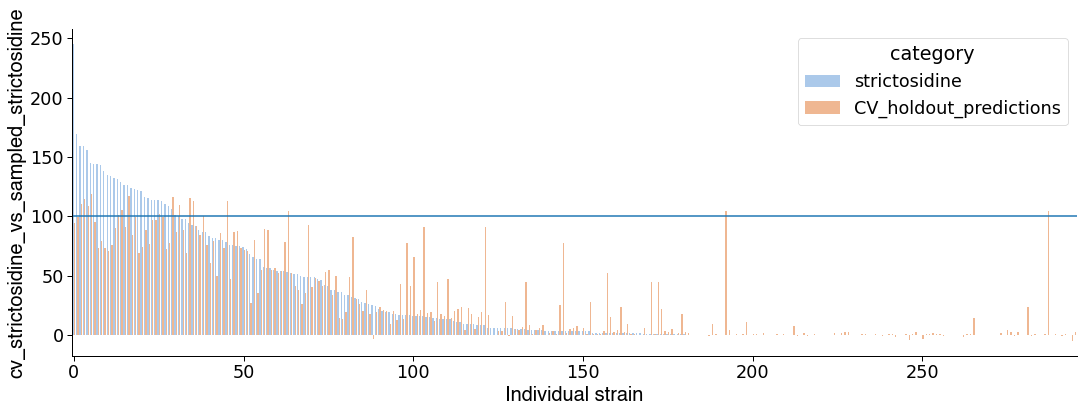

In [185]:
bar_plot_w_hue(dss, 'Line_name', 'strict', path = 'ConStrain_on_google_colab/data/10-plots/11_2_LEARN_Data_analysis/Bar_plot_prediction_vs_the_sampled_library', #ConStrain_on_google_colab/data/10-plots/11_2_LEARN_Data_analysis/Bar_plot_prediction_vs_the_sampled_library
              x_label = 'Individual strain',
               hue = 'category',
               palette = 'pastel',
               y_label= 'cv_strictosidine_vs_sampled_strictosidine', 
                size_height = 6,
                size_length = 18
              )

#### CV-Holdout predictions vs measured correlation plot

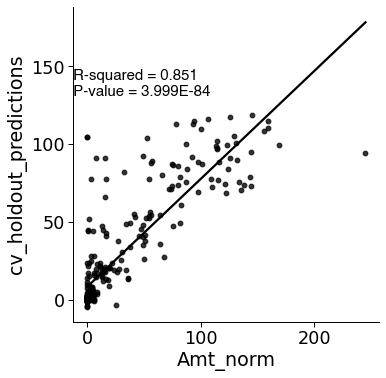

In [271]:
correlation_plot(df3,"Amt_norm","cv_holdout_predictions", 
                path = 'ConStrain_on_google_colab/data/10-plots/11_2_LEARN_Data_analysis/corr_plot_normalized_val',

                size_height = 5, 
                size_length= 5)

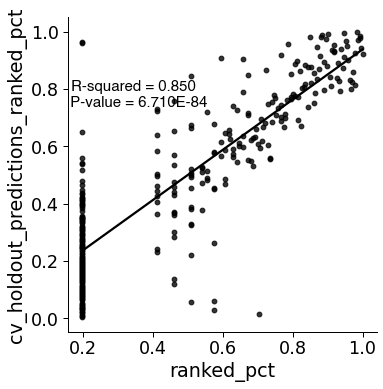

In [189]:
correlation_plot(df3,"ranked_pct","cv_holdout_predictions_ranked_pct",
                path = 'ConStrain_on_google_colab/data/10-plots/11_2_LEARN_Data_analysis/corr_plot_ranked',
                size_height = 5, 
                size_length= 5)

### 4.3 Find predicted genotypes

In [272]:
import numpy as np

In [273]:
all_genotypes = pd.read_csv('ConStrain_on_google_colab/data/09-AutoML/genotypes_for_ml/remaining_genotypes_after_first_iteration.csv',)
all_genotypes =all_genotypes[['0','1','2','3']]
all_genotypes

,0,1,2,3
0,1,1,5,1
1,1,1,5,2
2,1,1,5,4
3,1,1,5,5
4,1,1,5,7
...,...,...,...,...
1117,8,4,8,6
1118,8,4,8,7
1119,8,4,8,8
1120,8,4,8,9


In [274]:
all_genotypes_df = h2o.H2OFrame(pd.concat([all_genotypes], axis='columns'))
all_genotypes_df

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


0,1,2,3
1,1,5,1
1,1,5,2
1,1,5,4
1,1,5,5
1,1,5,7
1,1,5,8
1,1,5,9
1,1,6,1
1,1,6,2
1,1,6,3


In [193]:
input_fixed = new_input_for_ml[['0','1','2','3']]
input_fixed

,0,1,2,3
0,1,2,5,1
1,1,2,5,9
2,2,4,7,3
3,2,1,5,7
4,3,3,6,1
...,...,...,...,...
124,4,1,6,1
125,5,2,6,3
126,3,1,6,3
127,5,1,6,6


### 4.4 Getting rid of the genotypes we have already tested:

In [194]:
df_diff = all_genotypes[~all_genotypes.apply(tuple,1).isin(input_fixed.apply(tuple,1))]
df_diff.to_csv('ConStrain_on_google_colab/data/09-AutoML/genotypes_for_ml/remaining_genotypes_after_second_iteration.csv')
df_diff

,0,1,2,3
0,1,1,5,1
1,1,1,5,2
2,1,1,5,4
3,1,1,5,5
4,1,1,5,7
...,...,...,...,...
1117,8,4,8,6
1118,8,4,8,7
1119,8,4,8,8
1120,8,4,8,9


In [195]:
# make the diff into a df 
all_genotypes_df = h2o.H2OFrame(pd.concat([df_diff], axis='columns'))
all_genotypes_df['0']= all_genotypes_df['0'].asfactor()
all_genotypes_df['1']= all_genotypes_df['1'].asfactor()
all_genotypes_df['2'] = all_genotypes_df['2'].asfactor()
all_genotypes_df['3'] = all_genotypes_df['3'].asfactor()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


### 4.5 Predict the phenotype from the genotype of the unseen library

In [196]:
predicted = best_model.predict(all_genotypes_df)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


In [197]:
len(predicted)

1046

In [198]:
predicted_norm = predicted.as_data_frame()
predicted_norm.head()

,predict
0,0.208979
1,0.282979
2,0.895885
3,0.767943
4,0.149506


In [199]:
# making predictions into a list
predicted_list = predicted_norm['predict'].values.tolist()

# Adding predictions to our dataframe
df_diff['predicted_norm_strict'] = predicted_list

# Sorting the dataframe
predicted_merged_sorted = df_diff.sort_values('predicted_norm_strict', ascending=False)
predicted_merged_sorted

/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_7735/105107836.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_diff['predicted_norm_strict'] = predicted_list


,0,1,2,3,predicted_norm_strict
614,5,2,6,8,121.887856
610,5,2,6,4,120.655922
748,6,2,6,2,118.661545
752,6,2,6,8,116.150963
605,5,2,5,8,115.912682
...,...,...,...,...,...
862,7,1,7,1,-6.313099
864,7,1,7,3,-6.768794
865,7,1,7,4,-7.006977
866,7,1,7,5,-7.386846


If we want the names on the genotypes we can do the following: 

In [200]:
g8h_list_of_index = ["Cacu", "Opum","Cro","Vmin","Smus","Rsep","Oeu","Ccal"]
cpr_list_of_index = ["Cro", "Aan","Ara","Clo","Rse","Ahu","Ani","Cac","Oeu","Cpo"]
promoters = ["CYC1", "ENO2","PCK1","RPL15B", "CCW12", "TPI1","MLS1","URE2"]

g8h_genotype = []
cpr_genotype = []

pg8h_genotype = []
pcpr_genotype = []

predicted_list = []
# adding index of genotypes to individual rows 
for index, row in predicted_merged_sorted.iterrows():
    g8h_genotype.append(g8h_list_of_index[int(row['0'])-1])
    cpr_genotype.append(cpr_list_of_index[int(row['3'])-1])
    pg8h_genotype.append(promoters[int(row['1'])-1])
    pcpr_genotype.append(promoters[int(row['2'])-1])
    predicted_list.append(row['predicted_norm_strict'])
    
    
list_of_lists = [g8h_genotype,pg8h_genotype,pcpr_genotype, cpr_genotype, predicted_list  ]

## 5. Top 20 predicted producers

In [201]:
df_with_genotypes = pd.DataFrame(list_of_lists )
df_with_genotypes = df_with_genotypes.T
df_with_genotypes.columns = ['G8H', 'pG8H', 'pCPR', 'CPR', 'Predicted_strict_production']
df_with_genotypes.head(20)

,G8H,pG8H,pCPR,CPR,Predicted_strict_production
0,Smus,ENO2,TPI1,Cac,121.887856
1,Smus,ENO2,TPI1,Clo,120.655922
2,Rsep,ENO2,TPI1,Aan,118.661545
3,Rsep,ENO2,TPI1,Cac,116.150963
4,Smus,ENO2,CCW12,Cac,115.912682
5,Smus,ENO2,CCW12,Aan,115.522354
6,Smus,ENO2,CCW12,Clo,114.77845
7,Smus,ENO2,CCW12,Ara,110.120384
8,Rsep,ENO2,CCW12,Rse,109.848526
9,Rsep,ENO2,CCW12,Cac,108.326645


Saving the predictions

In [202]:
#Top20
df_with_genotypes_top20 = df_with_genotypes[:20]
df_with_genotypes_top20.to_csv('ConStrain_on_google_colab/data/09-AutoML/Top20_predictions/second_round/top20_ML_predicted_after_second_DBTL_2nd_analytics_1.csv')

# All predictions
df_with_genotypes.to_csv('ConStrain_on_google_colab/data/09-AutoML/all_predictions/second_round/top_ML_predicted_after_second_DBTL_2nd_analytics.csv', index=False)

In [203]:
from constrain.plotting.plotting import bar_plot
bar_plot

<function constrain.plotting.plotting.bar_plot(x: list, y: list, error_bar: list = None, horisontal_line=True, save_pdf=True, color='white', path='', title=None, x_label=None, y_label=None, size_height: int = 25, size_length: int = 15) -> None>

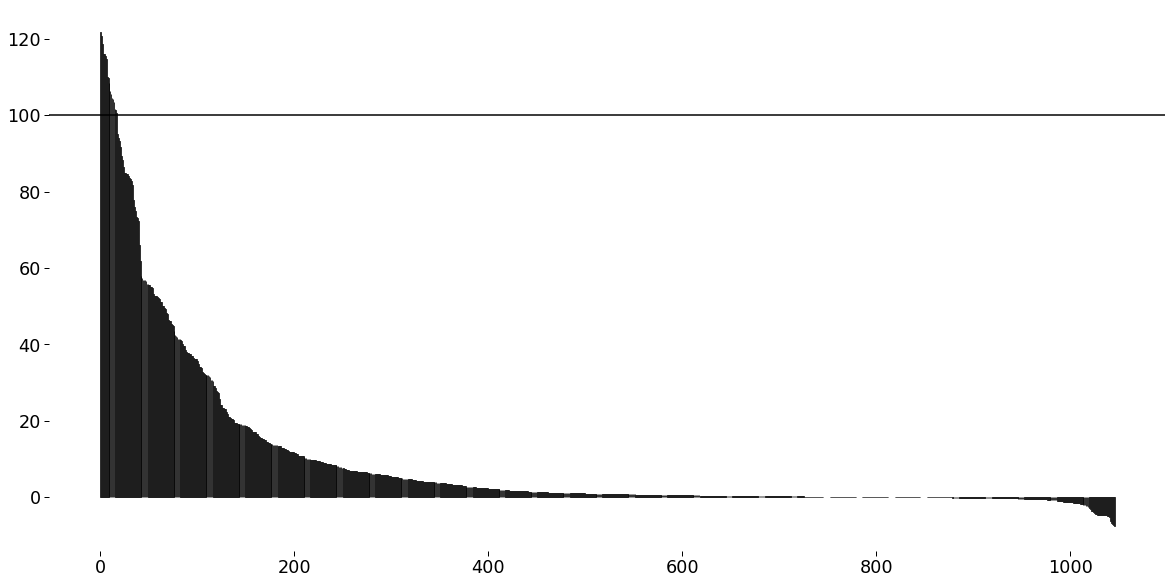

In [204]:
x = list(df_with_genotypes.index)
y = list(df_with_genotypes['Predicted_strict_production'])

bar_plot(x, y,
         path = 'ConStrain_on_google_colab/data/10-plots/11_2_LEARN_Data_analysis/barplot_predicting_remaining_best_combinations',
         size_height =  10, 
         size_length = 20)

In [205]:
df_with_genotypes = pd.read_csv('ConStrain_on_google_colab/data/09-AutoML/all_predictions/second_round/top_ML_predicted_after_second_DBTL_2nd_analytics.csv')

In [208]:
df_with_genotypes['names'] = df_with_genotypes['G8H']+'-' +df_with_genotypes['pG8H']+ '_'+ df_with_genotypes['pCPR']+'_'+df_with_genotypes['CPR']

In [209]:
df_with_genotypes

,G8H,pG8H,pCPR,CPR,Predicted_strict_production,names
0,Smus,ENO2,TPI1,Cac,121.887856,Smus-ENO2_TPI1_Cac
1,Smus,ENO2,TPI1,Clo,120.655922,Smus-ENO2_TPI1_Clo
2,Rsep,ENO2,TPI1,Aan,118.661545,Rsep-ENO2_TPI1_Aan
3,Rsep,ENO2,TPI1,Cac,116.150963,Rsep-ENO2_TPI1_Cac
4,Smus,ENO2,CCW12,Cac,115.912682,Smus-ENO2_CCW12_Cac
...,...,...,...,...,...,...
1041,Oeu,CYC1,MLS1,Cro,-6.313099,Oeu-CYC1_MLS1_Cro
1042,Oeu,CYC1,MLS1,Ara,-6.768794,Oeu-CYC1_MLS1_Ara
1043,Oeu,CYC1,MLS1,Clo,-7.006977,Oeu-CYC1_MLS1_Clo
1044,Oeu,CYC1,MLS1,Rse,-7.386846,Oeu-CYC1_MLS1_Rse


In [210]:
x_axis = list(df_with_genotypes['names'])[:20][::-1]
y_axis = list(df_with_genotypes['Predicted_strict_production'])[:20][::-1]

In [211]:
from constrain.plotting.plotting import horisontal_bar_plot

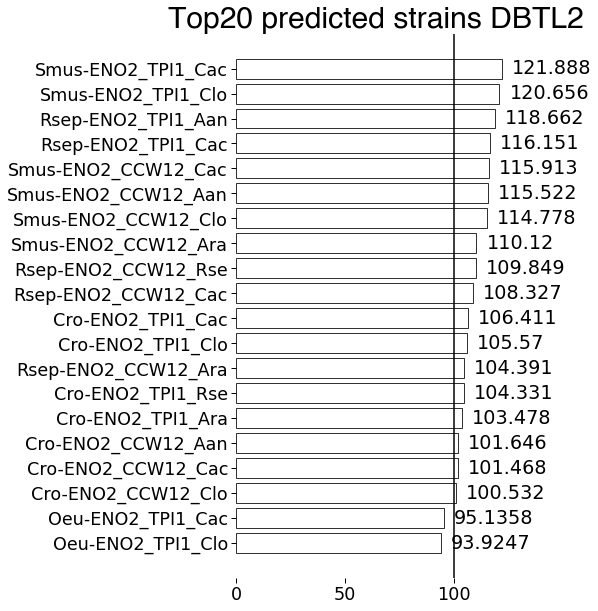

In [212]:
horisontal_bar_plot(x_axis,y_axis,  path = 'ConStrain_on_google_colab/data/10-plots/11_2_LEARN_Data_analysis/Top20_predicted_strains_ML2', 
                    title = 'Top20 predicted strains DBTL2', 
                   size_height=5, 
                   size_length=10)

### 5.1 How many genotypes are predicted to produce more than the control strain?

In [213]:
over_100_strict_procduction = df_with_genotypes[df_with_genotypes['Predicted_strict_production'] >= 100 ]
print(f"{len(over_100_strict_procduction)} strains out of {len(df_with_genotypes)} showed production of strictosidine over the normalized value")
print(f"Out of the remaing theoretical space these constittue : {(len(over_100_strict_procduction)/len(df_with_genotypes))*100}%")

18 strains out of 1046 showed production of strictosidine over the normalized value
Out of the remaing theoretical space these constittue : 1.7208413001912046%


### 5.2 How well does the model predict on the old library i.e. 1121? Do we get the same genotypes when sorting for the best as the the first model? 

In [214]:
all_genotypes_1121 = pd.read_csv('ConStrain_on_google_colab/data/09-AutoML/genotypes_for_ml/remaining_genotypes_after_first_iteration.csv', index_col= False)
all_genotypes =all_genotypes_1121[['0','1','2','3']]
all_genotypes_df = h2o.H2OFrame(pd.concat([all_genotypes], axis='columns'))

# Predict
predicted = best_model.predict(all_genotypes_df)

# make to dataframe
predicted_norm = predicted.as_data_frame()

# making predictions into a list
predicted_list = predicted_norm['predict'].values.tolist()

# Adding predictions to our dataframe
all_genotypes_1121['predicted_norm_strict'] = predicted_list

# Sorting the dataframe
predicted_merged_sorted = all_genotypes_1121.sort_values('predicted_norm_strict', ascending=False)
predicted_merged_sorted.to_csv('ConStrain_on_google_colab/data/09-AutoML/all_predictions/second_round_model_on_old_library/top_predictions_by_second_round_model_on_data_from_the_first_round.csv')

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


In [215]:
g8h_list_of_index = ["CacuG8H", "OpumG8H","CroG8H","VminG8H","SmusG8H","RsepG8H","OeuG8H","CcalG8H"]
cpr_list_of_index = ["CroCPR", "AanCPR","AraCPR","CloCPR","RseCPR","AhuCPR","AniCPR","CacCPR","OeuCPR","CpoCPR"]
promoters = ["CYC1", "ENO2","PCK1","RPL15B", "CCW12", "TPI1","MLS1","URE2"]

g8h_genotype = []
cpr_genotype = []

pg8h_genotype = []
pcpr_genotype = []

predicted_list = []
# adding index of genotypes to individual rows 
for index, row in predicted_merged_sorted.iterrows():
    g8h_genotype.append(g8h_list_of_index[int(row['0'])-1])
    cpr_genotype.append(cpr_list_of_index[int(row['3'])-1])
    pg8h_genotype.append(promoters[int(row['1'])-1])
    pcpr_genotype.append(promoters[int(row['2'])-1])
    predicted_list.append(row['predicted_norm_strict'])
    
    
list_of_lists = [g8h_genotype,pg8h_genotype,pcpr_genotype, cpr_genotype, predicted_list  ]

In [216]:
ML2_recomendations = pd.DataFrame(list_of_lists )
ML2_recomendations = ML2_recomendations.T

ML2_recomendations.columns = ['G8H', 'pG8H', 'pCPR', 'CPR', 'Predicted_strict_production']
ML2_recomendations100 = ML2_recomendations[:100]

In [217]:
# what it recomended in first round 
ML1_recomendations = pd.read_csv('ConStrain_on_google_colab/data/09-AutoML/all_predictions/first_round/top_ML_predicted_after_first_DBTL_merged_analytics.csv')
ML1_recomendations100 = ML1_recomendations[0:100]
ML1_recomendations100['G8H'] = ML1_recomendations100['G8H']+'G8H'
ML1_recomendations100['CPR'] = ML1_recomendations100['CPR']+'CPR'

ML1_recomendations100

/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_7735/839636308.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ML1_recomendations100['G8H'] = ML1_recomendations100['G8H']+'G8H'
/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_7735/839636308.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ML1_recomendations100['CPR'] = ML1_recomendations100['CPR']+'CPR'


,G8H,pG8H,pCPR,CPR,Predicted_strict_production
0,SmusG8H,ENO2,TPI1,CroCPR,189.410583
1,SmusG8H,ENO2,TPI1,CacCPR,184.930663
2,SmusG8H,ENO2,TPI1,AanCPR,183.786563
3,RsepG8H,ENO2,TPI1,AraCPR,179.451003
4,SmusG8H,ENO2,CCW12,AraCPR,177.130989
...,...,...,...,...,...
95,RsepG8H,ENO2,MLS1,AraCPR,52.550943
96,CroG8H,ENO2,CCW12,CloCPR,49.530658
97,SmusG8H,ENO2,MLS1,AanCPR,49.530375
98,OeuG8H,CYC1,TPI1,CacCPR,48.881757


In [218]:
ML1_recomendations100 = ML1_recomendations100[['G8H', 'pG8H', 'pCPR', 'CPR']]
ML2_recomendations100 = ML2_recomendations100[['G8H', 'pG8H', 'pCPR', 'CPR']]
ML2_recomendations100

,G8H,pG8H,pCPR,CPR
0,SmusG8H,ENO2,TPI1,AanCPR
1,SmusG8H,ENO2,TPI1,CacCPR
2,SmusG8H,ENO2,TPI1,CloCPR
3,RsepG8H,ENO2,TPI1,AanCPR
4,RsepG8H,ENO2,TPI1,CloCPR
...,...,...,...,...
95,OeuG8H,ENO2,URE2,CloCPR
96,RsepG8H,CYC1,CCW12,OeuCPR
97,RsepG8H,CYC1,TPI1,CroCPR
98,RsepG8H,CYC1,TPI1,OeuCPR


In [219]:
comparison = ML1_recomendations100.compare(ML2_recomendations100, keep_shape=True, keep_equal=True)
comparison

G8H           pG8H         pCPR            CPR        
       self    other  self other   self  other    self   other
0   SmusG8H  SmusG8H  ENO2  ENO2   TPI1   TPI1  CroCPR  AanCPR
1   SmusG8H  SmusG8H  ENO2  ENO2   TPI1   TPI1  CacCPR  CacCPR
2   SmusG8H  SmusG8H  ENO2  ENO2   TPI1   TPI1  AanCPR  CloCPR
3   RsepG8H  RsepG8H  ENO2  ENO2   TPI1   TPI1  AraCPR  AanCPR
4   SmusG8H  RsepG8H  ENO2  ENO2  CCW12   TPI1  AraCPR  CloCPR
..      ...      ...   ...   ...    ...    ...     ...     ...
95  RsepG8H   OeuG8H  ENO2  ENO2   MLS1   URE2  AraCPR  CloCPR
96   CroG8H  RsepG8H  ENO2  CYC1  CCW12  CCW12  CloCPR  OeuCPR
97  SmusG8H  RsepG8H  ENO2  CYC1   MLS1   TPI1  AanCPR  CroCPR
98   OeuG8H  RsepG8H  CYC1  CYC1   TPI1   TPI1  CacCPR  OeuCPR
99  SmusG8H   OeuG8H  ENO2  ENO2   TPI1   URE2  AhuCPR  RseCPR

[100 rows x 8 columns]

In [220]:
comparison.to_csv('ConStrain_on_google_colab/data/09-AutoML/all_predictions/second_round_model_on_old_library/ML1_top_predicted_vs_ML2_top100_predicted.csv')

In [221]:
difference = pd.concat([ML1_recomendations100,ML2_recomendations100]).drop_duplicates(keep=False)
the_same_rows = len(ML1_recomendations100) -len(difference)

In [222]:
print(f'The top predictions from the ML model in the second dbtl are share by the first round by {the_same_rows/len(ML1_recomendations100)*100}%')

The top predictions from the ML model in the second dbtl are share by the first round by 60.0%


### 5.3 Plotting the top predictions 

In [223]:
from constrain.plotting.plotting import color_range_dict
# importing a range of colors
cpr_color = color_range_dict()['yellow'][::2][::-1]
print(len(cpr_color))
pcpr_color = color_range_dict()['orange'][::6][::-1]
print(len(pcpr_color))
g8H_color= color_range_dict()['blue'][::3][::-1]
print(len(g8H_color))
pg8h_color = color_range_dict()['green'][::5][::-1]
print(len(pg8h_color))

10
4
8
4


In [224]:
g8h_list_of_index = ["CacuG8H", "OpumG8H","CroG8H","VminG8H","SmusG8H","RsepG8H","OeuG8H","CcalG8H"]
cpr_list_of_index = ["CroCPR", "AanCPR","AraCPR","CloCPR","RseCPR","AhuCPR","AniCPR","CacCPR","OeuCPR","CpoCPR"]
pg8h_list_of_index = ["CYC1", "ENO2","PCK1","RPL15B"]
pcpr_list_of_index = ["CCW12", "TPI1","MLS1","URE2"]
all_parts = g8h_list_of_index + pg8h_list_of_index+pcpr_list_of_index+cpr_list_of_index

G8H_color_codes = dict(zip(g8h_list_of_index, g8H_color))
pG8H_color_codes = dict(zip(pg8h_list_of_index, pg8h_color))
pCPR_color_codes = dict(zip(pcpr_list_of_index, pcpr_color))
CPR_color_codes = dict(zip(cpr_list_of_index, cpr_color))

colorDict = dict(G8H_color_codes, **pG8H_color_codes,**pCPR_color_codes, **CPR_color_codes)

In [225]:
from constrain.plotting.plotting import carpet_barplot

26


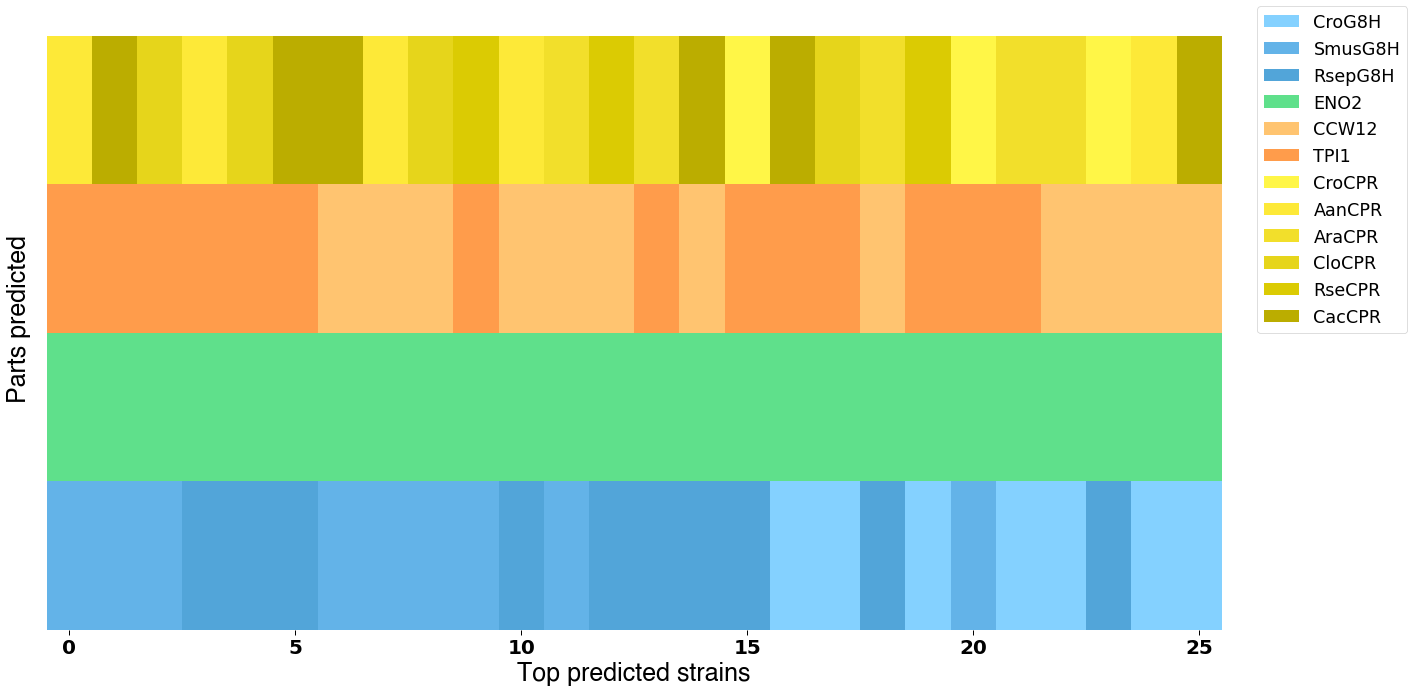

In [227]:
ML2_recomendations100['Index'] = ML2_recomendations100.index
list_of_parts = []
parst_index = []

for index, row in ML2_recomendations100.iterrows():
    list_of_parts.append(row['G8H'])
    list_of_parts.append(row['pG8H'])
    list_of_parts.append(row['pCPR'])
    list_of_parts.append(row['CPR'])
    parst_index.append(index)
    parst_index.append(index)
    parst_index.append(index)
    parst_index.append(index)


distribution = [25]*len(parst_index)

d = {'Index':parst_index,'Part':list_of_parts, 'Distribution':distribution }
df2 = pd.DataFrame(d)

# slice df
df200 = df2[:104]
cross_tab_prop = pd.crosstab(index=df200['Index'],
                             columns=df200['Part'])

coloumns = list(cross_tab_prop.columns)


print(len(cross_tab_prop))
# fix coloumns
coloumns = list(cross_tab_prop.columns)
fixed_columns = []
for name in all_parts:     
    if name in coloumns: 
        fixed_columns.append(name)

# get only the columns we use
cross_tab_prop = cross_tab_prop[fixed_columns]

name = 'Best_combinations_predicted_by_the_ML2_26_'
carpet_barplot(cross_tab_prop, colorDict, save_pdf= True , path ='ConStrain_on_google_colab/data/10-plots/11_2_LEARN_Data_analysis/'+name, xlabel ='Top predicted strains' ,
               ylabel = 'Parts predicted', 
              size_height= 10, 
              size_length=20) 



## 6. Learning curve on data

In [228]:
from constrain.machine_learning.auto_ml import autoML_on_partitioned_data

In [229]:
new_input_for_ml

,Line_name,0,1,2,3,Amt_uM_Strictosidine,Amt_norm
0,yp49_A01,1,2,5,1,0.271199,0
1,yp49_C01,1,2,5,9,0.149626,0
2,yp49_D01,2,4,7,3,0.049042,0
3,yp49_E01,2,1,5,7,0.096246,0
4,yp49_F01,3,3,6,1,7.365141,25
...,...,...,...,...,...,...,...
124,yp54_A04,4,1,6,1,4.326963,15
125,yp54_C04,5,2,6,3,26.634041,94
126,yp54_C09,3,1,6,3,13.122270,46
127,yp54_D12,5,1,6,6,1.049920,3


To make sure we dont see the experimental differences between the different runs we can shuffle the data (see below)

In [230]:
shuffled_new_input_for_ml = new_input_for_ml.sample(frac=1, random_state= 1).reset_index(drop=True) # Random state sets a seed on the shuffeling
shuffled_new_input_for_ml

,Line_name,0,1,2,3,Amt_uM_Strictosidine,Amt_norm
0,yp54_A02,4,1,5,1,6.808027,24
1,yp53_E11,7,1,5,5,0.477411,1
2,yp54_F03,7,2,5,7,0.723004,2
3,yp53_F09,6,1,5,7,0.516183,1
4,yp54_A05,5,2,6,1,31.958430,113
...,...,...,...,...,...,...,...
291,yp53_D06,4,2,6,5,30.736762,109
292,yp54_B11,4,1,6,3,1.799734,6
293,yp50_C03,4,2,6,9,19.840166,57
294,yp53_E01,6,1,5,5,11.753071,41


This function takes 20+ hours to run. 

In [231]:
#feature_cols = ['0', '1', '2', '3']
#training_column = 'Amt_norm'
#
## Training 5 partitions 3 times - the function is set to nfold = 10  by default. 
#for i in range(0,3): 
#    autoML_on_partitioned_data(feature_cols, training_column,
#                               shuffled_new_input_for_ml,
#                               training_time=0, 
#                               partitions = 5,
#                               nfold= 10,
#                               path = '/Users/lucaslevassor/projects/ConStrain/colab_notebooks/ConStrain_on_google_colab/data/09-AutoML/learning_curve_data/second_round/nfold_10/0sec_experiment/shuffled_random1/')

### 6.1 - Visiualizing the learning curve

In [232]:
import os

# folder path
dir_path = 'ConStrain_on_google_colab/data/09-AutoML/learning_curve_data/second_round/nfold_10/0sec_experiment/shuffled_random1/'

# list file and directories
res = os.listdir(dir_path)
res

['.DS_Store',
 '2023_01_11_10:06_ml_models_running_over_partioned_data_df1_df2.csv',
 '2023_01_08_10:55_ml_models_running_over_partioned_data_df2_df1.csv',
 '2023_01_08_19:43_ml_models_running_over_partioned_data_df2_df1.csv',
 '2023_01_11_15:04_ml_models_running_over_partioned_data_df1_df2.csv',
 '2023_01_11_05:14_ml_models_running_over_partioned_data_df1_df2.csv',
 '2023_01_09_00:37_ml_models_running_over_partioned_data_df2_df1.csv']

In [233]:
lst_of_pd_dataframes = []
for ml_partitioned in res:
    if ml_partitioned.endswith('.csv'):
        lst_of_pd_dataframes.append(pd.read_csv(dir_path+ml_partitioned))

Lets retrieve the data 

In [234]:
dfs = [df.set_index('Unnamed: 0') for df in lst_of_pd_dataframes[3:]]
concated = pd.concat(dfs, axis=1)
concated

,0,CV_mean_MAE,CV_SD_MAE,Model_name,0,CV_mean_MAE,CV_SD_MAE,Model_name,0,CV_mean_MAE,CV_SD_MAE,Model_name
Unnamed: 0,,,,,,,,,,,,
60,20.265256,24.947948,11.087297,XGBoost_lr_search_selection_AutoML_26_20230111...,16.737130,20.445763,11.993407,StackedEnsemble_BestOfFamily_6_AutoML_16_20230...,7.428000,14.660718,7.493557,StackedEnsemble_BestOfFamily_7_AutoML_26_20230...
120,12.279735,18.538673,6.700190,StackedEnsemble_AllModels_5_AutoML_28_20230111...,12.173079,17.226658,9.652630,XGBoost_lr_search_selection_AutoML_17_20230111...,6.358275,12.685257,8.597869,XGBoost_lr_search_selection_AutoML_27_20230108...
180,10.961404,16.290192,4.917861,StackedEnsemble_BestOfFamily_7_AutoML_30_20230...,11.479273,14.279459,5.249099,StackedEnsemble_BestOfFamily_6_AutoML_18_20230...,9.702213,12.834663,4.162396,StackedEnsemble_AllModels_5_AutoML_28_20230108...
240,10.178009,15.006841,6.094630,GBM_grid_1_AutoML_32_20230111_130319_model_12,10.178009,15.006841,6.094630,GBM_grid_1_AutoML_19_20230111_31558_model_12,8.611914,12.872042,3.526086,XGBoost_lr_search_selection_AutoML_29_20230108...
296,10.048070,14.349804,4.571663,GBM_grid_1_AutoML_34_20230111_140339_model_12,10.119082,14.098402,4.570198,GBM_lr_annealing_selection_AutoML_20_20230111_...,9.448801,12.660960,3.520006,XGBoost_lr_search_selection_AutoML_30_20230108...


In [235]:

# test results
test_results = concated[['0']]
test_results['mean'] = test_results.mean(axis=1)
test_results['std'] = test_results.std(axis=1)
test_results

/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_7735/2914699888.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_results['mean'] = test_results.mean(axis=1)
/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_7735/2914699888.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_results['std'] = test_results.std(axis=1)


,0,0,0,mean,std
Unnamed: 0,,,,,
60,20.265256,16.737130,7.428000,14.810129,5.415028
120,12.279735,12.173079,6.358275,10.270363,2.766606
180,10.961404,11.479273,9.702213,10.714297,0.746227
240,10.178009,10.178009,8.611914,9.655977,0.738264
296,10.048070,10.119082,9.448801,9.871984,0.300637


In [236]:

# Cross-validated mean MAE
cross_validated_results = concated[['CV_mean_MAE']]
cross_validated_results['mean'] = cross_validated_results.mean(axis=1)
cross_validated_results

/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_7735/1005275068.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cross_validated_results['mean'] = cross_validated_results.mean(axis=1)


,CV_mean_MAE,CV_mean_MAE,CV_mean_MAE,mean
Unnamed: 0,,,,
60,24.947948,20.445763,14.660718,20.018143
120,18.538673,17.226658,12.685257,16.150196
180,16.290192,14.279459,12.834663,14.468105
240,15.006841,15.006841,12.872042,14.295241
296,14.349804,14.098402,12.660960,13.703055


In [237]:
# Cross-validated mean SD
cross_validated_results_sd = concated[['CV_SD_MAE']]
cross_validated_results_sd['mean'] = cross_validated_results_sd.mean(axis=1)
cross_validated_results_sd

/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_7735/3504483626.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cross_validated_results_sd['mean'] = cross_validated_results_sd.mean(axis=1)


,CV_SD_MAE,CV_SD_MAE,CV_SD_MAE,mean
Unnamed: 0,,,,
60,11.087297,11.993407,7.493557,10.191420
120,6.700190,9.652630,8.597869,8.316896
180,4.917861,5.249099,4.162396,4.776452
240,6.094630,6.094630,3.526086,5.238449
296,4.571663,4.570198,3.520006,4.220622


In [238]:
from constrain.plotting.plotting import plot_ml_learning_curve

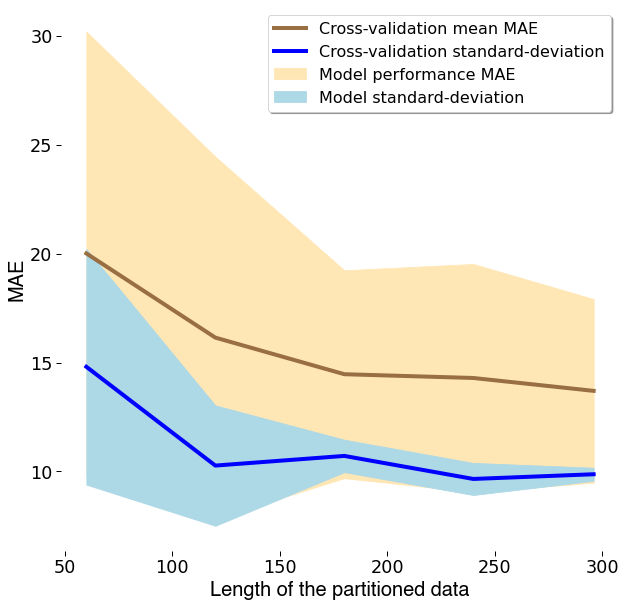

In [239]:
# CV
x = list(cross_validated_results.index)
y = list(cross_validated_results['mean'])
sd =  np.array(list(cross_validated_results_sd['mean']))

# model_performance
y1 = list(test_results['mean'])
sd1 = np.array(list(test_results['std']))

plot = plot_ml_learning_curve(x, y1, y,sd1,  sd, save_pdf = True , 
                              path = 'ConStrain_on_google_colab/data/10-plots/11_2_LEARN_Data_analysis/Learning_curve_on_partitioned_data_DBTL2_10_height_10_length.pdf', 
                             size_height = 10,
                             size_length = 10, 
                             linewidth=4)

In [240]:
h2o.shutdown()

H2O session _sid_a7d1 closed.


/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_7735/2900054706.py:1: H2ODeprecationWarning: Deprecated, use ``h2o.cluster().shutdown()``.
  h2o.shutdown()
